In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns

from DataFormat  import DataFormat
from read_data   import read_data
from calibration import read_calibration_parameters, linear_calibration

from matplotlib.colors import LogNorm

In [2]:
DATA_PATH   = "./data"

LABR_A  = "labr-a"
LABR_B  = "labr-b"
CLYC    = "clyc"
PLASTIC = "plastic"

RUN_DAYS = [2, 3]

In [3]:
time_windows = [50, 100, 500, 1000, 5000, 10000, 50000, 100000] # in ns

### LaBr3 A

In [4]:
# read coincidence data
labra_coincidence = pd.DataFrame(
    columns=['board', 'channel', 'flag', 'timestamp', 'energy', 'energy_short', 'energy_calib', 'energy_short_calib', 'psd', 'psd_calib', 'id', 'Particle', 'time_window', 'run_day']
)

for tw in time_windows:
    for run_day in RUN_DAYS:
        df = pd.read_csv(f"{DATA_PATH}/labra-coincidence-day{run_day}-{tw}ns.csv")
        df.loc[:, "time_window"] = tw
        df.loc[:, "run_day"]     = run_day
        labra_coincidence = labra_coincidence.append(df, ignore_index=True)
        
# place the id column at the beginning
# drop board channel flag columns
labra_coincidence = labra_coincidence[["id", "run_day", "time_window", "timestamp", "energy", "energy_short", "energy_calib", "energy_short_calib", "psd", "psd_calib", "Particle"]]

In [5]:
labra_coincidence

,id,run_day,time_window,timestamp,energy,energy_short,energy_calib,energy_short_calib,psd,psd_calib,Particle
0,641,2,50,2333175639936,376,106,1873.989873,506.901266,0.718085,0.729507,Neutron
1,1546,2,50,2333175619718,62,62,217.150205,217.150205,0.000000,0.000000,Gamma
2,21150,2,50,78699709956874,903,282,4542.344304,1398.040506,0.687708,0.692220,Neutron
3,51189,2,50,78699709965328,88,88,303.079736,303.079736,0.000000,0.000000,Gamma
4,33998,2,50,126234206747779,570,169,2856.268354,825.888608,0.703509,0.710850,Neutron
...,...,...,...,...,...,...,...,...,...,...,...
43798,8521056,3,100000,15865187941425202,1241,1236,4113.723953,4097.199043,0.004029,0.004017,Gamma
43799,3222627,3,100000,15865215388693733,543,169,2719.559494,825.888608,0.688766,0.696315,Neutron
43800,8521071,3,100000,15865215366709280,39,39,141.135620,141.135620,0.000000,0.000000,Gamma
43801,3223213,3,100000,15868321557566468,1339,432,6749.939241,2157.534177,0.677371,0.680362,Neutron


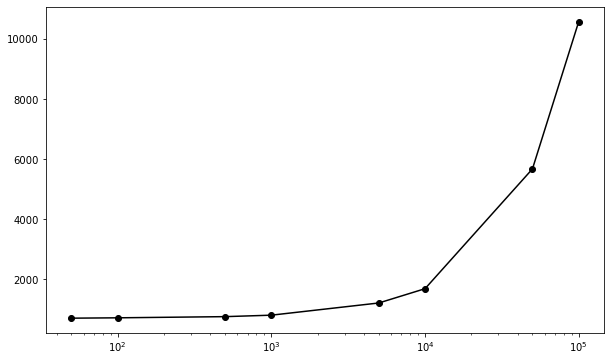

In [7]:
# for each time window count the number of Gamma coincidences and plot the number of coincidences as a function of the time window
labra_gamma = labra_coincidence[labra_coincidence["Particle"] == "Gamma"]
labra_gamma_grouped = labra_gamma.groupby("time_window").count()["id"]

fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(111)

ax.plot(labra_gamma_grouped.index, labra_gamma_grouped.values, marker="o", color="black")
ax.set_xscale("log")

plt.show()

In [161]:
# for each time window, count how many Gamma particles are found between two Neutron particles
counts = labra_coincidence.groupby(["time_window", "run_day", "Particle"]).count()["id"]
counts

time_window  run_day  Particle
50           2        Gamma        309
                      Neutron      309
             3        Gamma        396
                      Neutron      396
100          2        Gamma        316
                      Neutron      316
             3        Gamma        401
                      Neutron      401
500          2        Gamma        332
                      Neutron      332
             3        Gamma        424
                      Neutron      424
1000         2        Gamma        353
                      Neutron      353
             3        Gamma        452
                      Neutron      452
5000         2        Gamma        563
                      Neutron      563
             3        Gamma        648
                      Neutron      648
10000        2        Gamma        812
                      Neutron      812
             3        Gamma        875
                      Neutron      874
50000        2        Gamma      

In [98]:
def count_gamma_between_neutrons(df):
    # Find the indices of the Neutron particles
    neutron_indices = df[df["Particle"] == "Neutron"].index
    # Initialize an empty list to store the counts of Gamma particles
    gamma_counts = []
    # Iterate over the indices of the Neutron particles
    for i in range(len(neutron_indices) - 1):
        # Get the start and end indices for the current time window
        start_index = neutron_indices[i]
        end_index = neutron_indices[i+1]
        # Count the number of Gamma particles in the current time window
        gamma_count = df.loc[start_index:end_index, "Particle"].value_counts()["Gamma"]
        # Append the count to the list
        gamma_counts.append(gamma_count)
    # Return the list of counts
    return gamma_counts

# Group the dataframe by the "time_window" column
grouped_df = labra_coincidence.groupby("time_window")

# Apply the count_gamma_between_neutrons function to each group
gamma_counts_by_time_window = grouped_df.apply(count_gamma_between_neutrons)


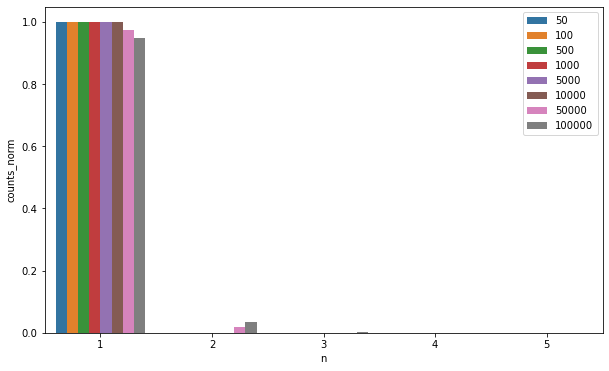

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

n_df = pd.DataFrame(columns=["time_window", "n", "counts"])

# Iterate over the time windows
for time_window, gamma_counts in gamma_counts_by_time_window.items():

    # compute how many ones there are in the gamma_counts list
    ones = gamma_counts.count(1)
    twos = gamma_counts.count(2)
    three = gamma_counts.count(3)
    four = gamma_counts.count(4)
    five = gamma_counts.count(5)
    
    n_df = n_df.append({"time_window": time_window, "n": 1, "counts": ones}, ignore_index=True)
    n_df = n_df.append({"time_window": time_window, "n": 2, "counts": twos}, ignore_index=True)
    n_df = n_df.append({"time_window": time_window, "n": 3, "counts": three}, ignore_index=True)
    n_df = n_df.append({"time_window": time_window, "n": 4, "counts": four}, ignore_index=True)
    n_df = n_df.append({"time_window": time_window, "n": 5, "counts": five}, ignore_index=True)
   
   
# normalize the counts to the total number of coincidences
for tw in time_windows:
    tot = labra_coincidence[labra_coincidence["time_window"] == tw].count()["id"]
    n_df.loc[n_df["time_window"] == tw, "counts_norm"] = n_df.loc[n_df["time_window"] == tw, "counts"] / tot * 2


ax = sns.barplot(x="n", y="counts_norm", hue="time_window", data=n_df, ax=ax) 
ax.legend()

plt.show()
    
    

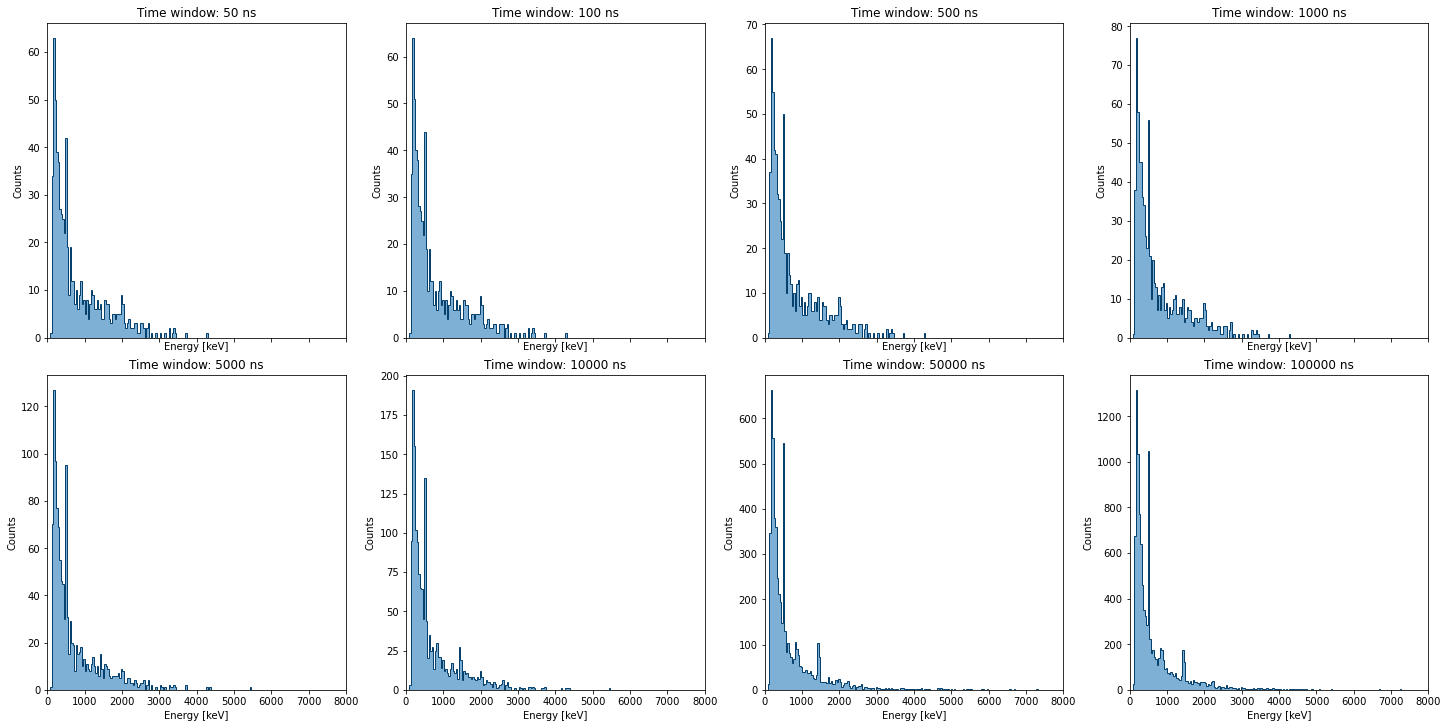

In [162]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True, sharex=True)

for i, tw in enumerate(time_windows):
    ax[i//4, i%4].hist(
        labra_gamma[labra_gamma["time_window"] == tw]["energy_calib"],
        bins      = np.linspace(0, 8000, 200), 
        histtype  = "stepfilled", 
        edgecolor = "#06416D", 
        facecolor = "#7eb0d5",
        label     = f"{tw} ns"
    )

    ax[i//4, i%4].set_xlim(0, 8000)
    ax[i//4, i%4].set_xlabel("Energy [keV]")
    ax[i//4, i%4].set_ylabel("Counts")

    ax[i//4, i%4].set_title(f"Time window: {int(tw)} ns")
    
    
# fig.savefig("./plots/labra_e_hist_coincidence_windows.png", dpi=300, facecolor="white")
plt.show()


### LaBr3 B

In [5]:
# read coincidence data
labrb_coincidence = pd.DataFrame(
    columns=['board', 'channel', 'flag', 'timestamp', 'energy', 'energy_short', 'energy_calib', 'energy_short_calib', 'psd', 'psd_calib', 'id', 'Particle', 'time_window', 'run_day']
)

for tw in time_windows:
    for run_day in RUN_DAYS:
        df = pd.read_csv(f"{DATA_PATH}/labrb-coincidence-day{run_day}-{tw}ns.csv")
        df.loc[:, "time_window"] = tw
        df.loc[:, "run_day"]     = run_day
        labrb_coincidence = labrb_coincidence.append(df, ignore_index=True)
        
# place the id column at the beginning
# drop board channel flag columns
labrb_coincidence = labrb_coincidence[["id", "run_day", "time_window", "timestamp", "energy", "energy_short", "energy_calib", "energy_short_calib", "psd", "psd_calib", "Particle"]]

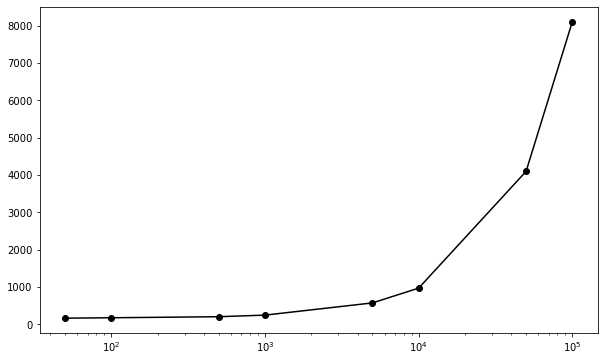

In [9]:
# for each time window count the number of Gamma coincidences and plot the number of coincidences as a function of the time window
labrb_gamma = labrb_coincidence[labrb_coincidence["Particle"] == "Gamma"]
labrb_gamma_grouped = labrb_gamma.groupby("time_window").count()["id"]

fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(111)

ax.plot(labrb_gamma_grouped.index, labrb_gamma_grouped.values, marker="o", color="black")
ax.set_xscale("log")

plt.show()

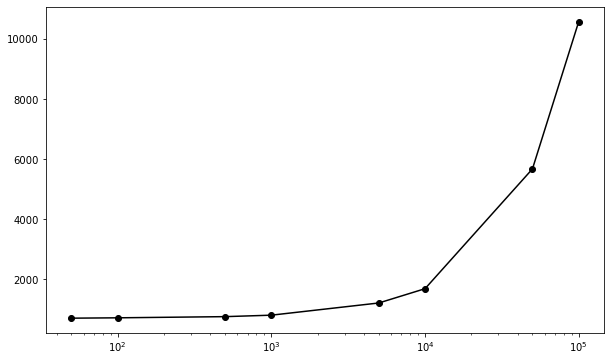

In [10]:
# for each time window count the number of Gamma coincidences and plot the number of coincidences as a function of the time window
labra_gamma = labra_coincidence[labra_coincidence["Particle"] == "Gamma"]
labra_gamma_grouped = labra_gamma.groupby("time_window").count()["id"]

fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(111)

ax.plot(labra_gamma_grouped.index, labra_gamma_grouped.values, marker="o", color="black")
ax.set_xscale("log")

plt.show()

In [20]:
from scipy.optimize import curve_fit

def linear(x, a, b):
    return a * x + b

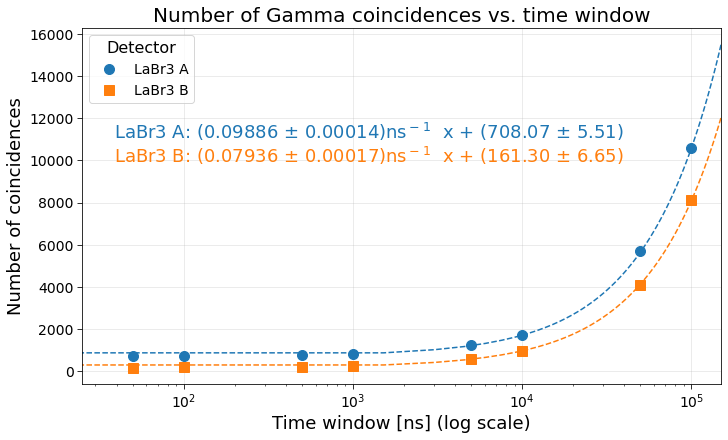

In [88]:
# plot both detectors

fig = plt.figure(figsize=(10, 6), constrained_layout=True)

ax = fig.add_subplot(111)


par_a, cov_a = curve_fit(linear, labra_gamma_grouped.index, labra_gamma_grouped.values)
par_b, cov_b = curve_fit(linear, labrb_gamma_grouped.index, labrb_gamma_grouped.values)

# compute the chi2
chi2_a = np.sum((linear(labra_gamma_grouped.index, *par_a) - labra_gamma_grouped.values)**2 / labra_gamma_grouped.values)
chi2_b = np.sum((linear(labrb_gamma_grouped.index, *par_b) - labrb_gamma_grouped.values)**2 / labrb_gamma_grouped.values)




xgrid = np.linspace(0, 150000, 100)

ax.plot(xgrid, linear(xgrid, *par_a), ls="--", color="tab:blue")
ax.plot(xgrid, linear(xgrid, *par_b), ls="--", color="tab:orange")


ax.plot(labra_gamma_grouped.index, labra_gamma_grouped.values, marker="o", markersize=10, ls="", label="LaBr3 A", color="tab:blue")
ax.plot(labrb_gamma_grouped.index, labrb_gamma_grouped.values, marker="s", markersize=10, ls="", label="LaBr3 B", color="tab:orange") 

ax.legend(fontsize=14, title_fontsize=16, title="Detector", loc="best")
ax.set_xscale("log")

ax.set_xlim(25, 150000)

ax.set_title("Number of Gamma coincidences vs. time window", fontsize=20)
ax.set_xlabel("Time window [ns] (log scale)", fontsize=18)
ax.set_ylabel("Number of coincidences", fontsize=18)

ax.tick_params(axis="both", which="major", labelsize=14, length=5)


# ax.text(0.05, 0.65, f"$\chi^2$ LaBr3 A: {chi2_a:.2f}", transform=ax.transAxes, fontsize=18)
# ax.text(0.05, 0.60, f"$\chi^2$ LaBr3 B: {chi2_b:.2f}", transform=ax.transAxes, fontsize=18)

# display the linear function with parameters and error
ax.text(
    0.05,
    0.49 + 0.2,
    f"LaBr3 A: ({par_a[0]:.5f} $\pm$ {np.sqrt(cov_a[0, 0]):.5f})ns$^-$$^1$  x + ({par_a[1]:.2f} $\pm$ {np.sqrt(cov_a[1, 1]):.2f})",
    transform=ax.transAxes,
    fontsize=18,
    color="tab:blue",
)
ax.text(
    0.05,
    0.42 + 0.2,
    f"LaBr3 B: ({par_b[0]:.5f} $\pm$ {np.sqrt(cov_b[0, 0]):.5f})ns$^-$$^1$  x + ({par_b[1]:.2f} $\pm$ {np.sqrt(cov_b[1, 1]):.2f})",
    transform=ax.transAxes,
    fontsize=18,
    color="tab:orange",
)
ax.grid(alpha=0.3)
ax.set_axisbelow(True)

fig.savefig("plots/number_of_coincidences_vs_time_window.png", dpi=300, facecolor="white")

plt.show()

In [104]:
# for each time window, count how many Gamma particles are found between two Neutron particles
counts = labrb_coincidence.groupby(["time_window", "run_day", "Particle"]).count()["id"]
counts


time_window  run_day  Particle
50           2        Gamma         84
                      Neutron       84
             3        Gamma         76
                      Neutron       76
100          2        Gamma         87
                      Neutron       87
             3        Gamma         84
                      Neutron       84
500          2        Gamma        103
                      Neutron      103
             3        Gamma         96
                      Neutron       96
1000         2        Gamma        128
                      Neutron      128
             3        Gamma        114
                      Neutron      114
5000         2        Gamma        291
                      Neutron      291
             3        Gamma        278
                      Neutron      278
10000        2        Gamma        494
                      Neutron      492
             3        Gamma        472
                      Neutron      470
50000        2        Gamma      

In [69]:
def count_gamma_between_neutrons(df):
    # Find the indices of the Neutron particles
    neutron_indices = df[df["Particle"] == "Neutron"].index
    # Initialize an empty list to store the counts of Gamma particles
    gamma_counts = []
    # Iterate over the indices of the Neutron particles
    for i in range(len(neutron_indices) - 1):
        # Get the start and end indices for the current time window
        start_index = neutron_indices[i]
        end_index = neutron_indices[i+1]
        # Count the number of Gamma particles in the current time window
        gamma_count = df.loc[start_index:end_index, "Particle"].value_counts()["Gamma"]
        # Append the count to the list
        gamma_counts.append(gamma_count)
    # Return the list of counts
    return gamma_counts

# Group the dataframe by the "time_window" column
grouped_df_a = labra_coincidence.groupby("time_window")
grouped_df_b = labrb_coincidence.groupby("time_window")

# Apply the count_gamma_between_neutrons function to each group
gamma_counts_by_time_window_a = grouped_df_a.apply(count_gamma_between_neutrons)
gamma_counts_by_time_window_b = grouped_df_b.apply(count_gamma_between_neutrons)


In [77]:

n_df_a = pd.DataFrame(columns=["time_window", "n", "counts"])
n_df_b = pd.DataFrame(columns=["time_window", "n", "counts"])

# Iterate over the time windows
for time_window, gamma_counts in gamma_counts_by_time_window_a.items():

    # compute how many ones there are in the gamma_counts list
    ones = gamma_counts.count(1)
    twos = gamma_counts.count(2)
    three = gamma_counts.count(3)
    four = gamma_counts.count(4)
    five = gamma_counts.count(5)
    
    n_df_a = n_df_a.append({"time_window": time_window, "n": 1, "counts": ones}, ignore_index=True)
    n_df_a = n_df_a.append({"time_window": time_window, "n": 2, "counts": twos}, ignore_index=True)
    n_df_a = n_df_a.append({"time_window": time_window, "n": 3, "counts": three}, ignore_index=True)
    n_df_a = n_df_a.append({"time_window": time_window, "n": 4, "counts": four}, ignore_index=True)
    n_df_a = n_df_a.append({"time_window": time_window, "n": 5, "counts": five}, ignore_index=True)
    
# Iterate over the time windows
for time_window, gamma_counts in gamma_counts_by_time_window_b.items():

    # compute how many ones there are in the gamma_counts list
    ones = gamma_counts.count(1)
    twos = gamma_counts.count(2)
    three = gamma_counts.count(3)
    four = gamma_counts.count(4)
    five = gamma_counts.count(5)
    
    n_df_b = n_df_b.append({"time_window": time_window, "n": 1, "counts": ones}, ignore_index=True)
    n_df_b = n_df_b.append({"time_window": time_window, "n": 2, "counts": twos}, ignore_index=True)
    n_df_b = n_df_b.append({"time_window": time_window, "n": 3, "counts": three}, ignore_index=True)
    n_df_b = n_df_b.append({"time_window": time_window, "n": 4, "counts": four}, ignore_index=True)
    n_df_b = n_df_b.append({"time_window": time_window, "n": 5, "counts": five}, ignore_index=True)
   
   
# normalize the counts to the total number of coincidences
for tw in time_windows:
    tot_a = labra_coincidence[labra_coincidence["time_window"] == tw].count()["id"]
    tot_b = labrb_coincidence[labrb_coincidence["time_window"] == tw].count()["id"]
    n_df_a.loc[n_df_a["time_window"] == tw, "counts_norm"] = n_df_a.loc[n_df_a["time_window"] == tw, "counts"] / (tot_a/2 - 1)
    n_df_b.loc[n_df_b["time_window"] == tw, "counts_norm"] = n_df_b.loc[n_df_b["time_window"] == tw, "counts"] / (tot_b/2 - 1)
    

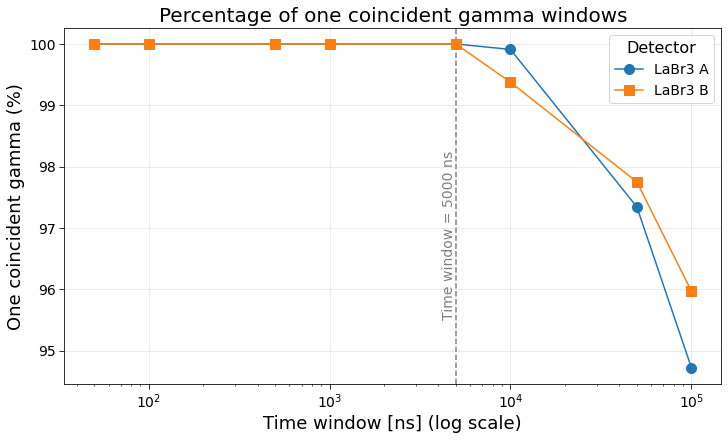

In [113]:
# plot the normalized number of 1 gamma coincidences and non-1 gamma coincidences for each time window

ndf_a = n_df_a[n_df_a["n"] == 1]
ndf_b = n_df_b[n_df_b["n"] == 1]

fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
ax.grid(alpha=0.3)
ax.set_axisbelow(True)

ax.plot(ndf_a["time_window"], ndf_a["counts_norm"]*100, marker="o", markersize=10, label="LaBr3 A", color="tab:blue")
ax.plot(ndf_b["time_window"], ndf_b["counts_norm"]*100, marker="s", markersize=10, label="LaBr3 B", color="tab:orange")

ax.legend(fontsize=14, title_fontsize=16, title="Detector", loc="best")
ax.set_xscale("log")

ax.set_title("Percentage of one coincident gamma windows", fontsize=20)
ax.set_xlabel("Time window [ns] (log scale)", fontsize=18)
ax.set_ylabel("One coincident gamma (%)", fontsize=18)

ax.tick_params(axis="both", which="major", labelsize=14, length=5)

# this is the last window that ensured 100% 1 gamma coincidences
ax.axvline(5000, color="k", linestyle="--", alpha=0.5, zorder=0)

# say that time window = 5000 ns is the time window that ensures 100% 1 gamma coincidences
ax.text(5000, 95.5, "Time window = 5000 ns", fontsize=14, rotation=90, va="bottom", ha="right", color="k", alpha=0.5)

fig.savefig("./plots/1-gamma-coincidences.png", dpi=300, facecolor="w")

plt.show()

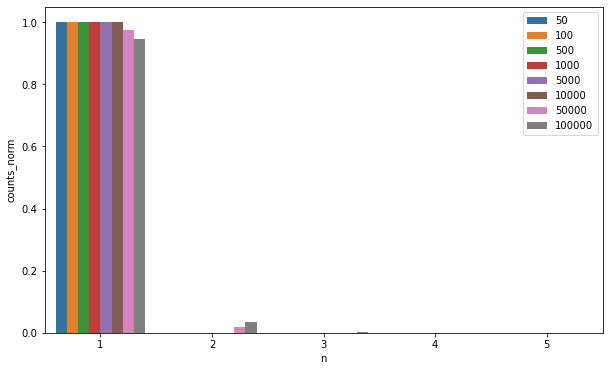

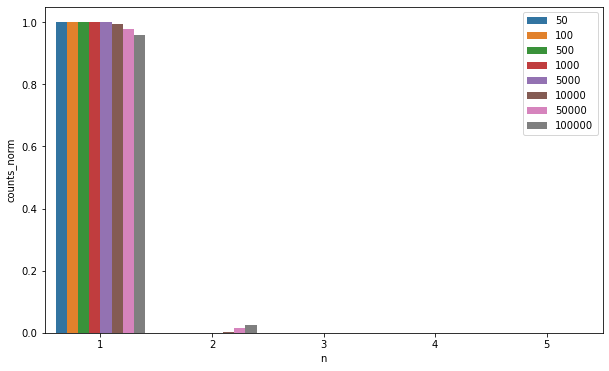

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax = sns.barplot(x="n", y="counts_norm", hue="time_window", data=n_df_a, ax=ax) 
ax.legend()

plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax = sns.barplot(x="n", y="counts_norm", hue="time_window", data=n_df_b, ax=ax) 
ax.legend()

plt.show()

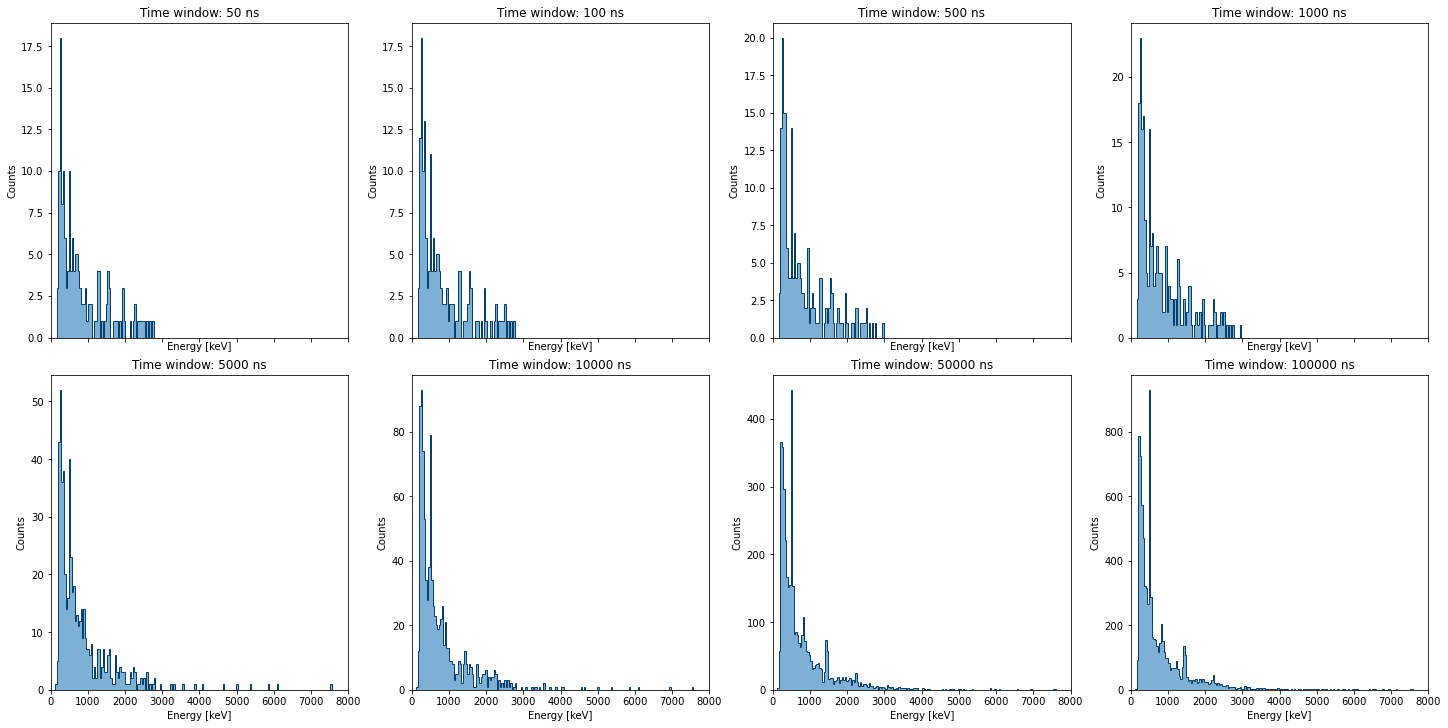

In [107]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True, sharex=True)

for i, tw in enumerate(time_windows):
    ax[i//4, i%4].hist(
        labrb_gamma[labrb_gamma["time_window"] == tw]["energy_calib"],
        bins      = np.linspace(0, 8000, 200), 
        histtype  = "stepfilled", 
        edgecolor = "#06416D", 
        facecolor = "#7eb0d5",
        label     = f"{tw} ns"
    )

    ax[i//4, i%4].set_xlim(0, 8000)
    ax[i//4, i%4].set_xlabel("Energy [keV]")
    ax[i//4, i%4].set_ylabel("Counts")

    ax[i//4, i%4].set_title(f"Time window: {int(tw)} ns")
    
    
fig.savefig("./plots/labrb_e_hist_coincidence_windows.png", dpi=300, facecolor="white")
plt.show()


# Gamma-neutron time distance

In [6]:
# compute time distance between a gamma and its closest neutron
def compute_time_distance(df):
    # Find the indices of the Neutron particles
    neutron_indices = df[df["Particle"] == "Neutron"].index
    # Initialize an empty list to store the counts of Gamma particles
    time_distances = []
    # Iterate over the indices of the Neutron particles
    for i in range(len(neutron_indices) - 1):
        # Get the start and end indices for the current time window
        start_index = neutron_indices[i]
        end_index = neutron_indices[i+1]
        # Count the number of Gamma particles in the current time window
        gamma_indices = df.loc[start_index:end_index, "Particle"].index[df.loc[start_index:end_index, "Particle"] == "Gamma"]
        # Iterate over the Gamma indices
        for gamma_index in gamma_indices:
            # Get the time difference between the Gamma and the Neutron
            # time_distance = df.loc[gamma_index, "timestamp"] - df.loc[neutron_indices[i], "timestamp"]
            # Get the time difference between Neutron - Gamma
            time_distance = df.loc[neutron_indices[i], "timestamp"] - df.loc[gamma_index, "timestamp"]
            # Append the count to the list
            time_distances.append(time_distance)
    # Return the list of counts
    return time_distances

In [186]:
time_w = 100

time_distance_a = compute_time_distance(labra_coincidence[labra_coincidence["time_window"] == time_w])
time_distance_b = compute_time_distance(labrb_coincidence[labrb_coincidence["time_window"] == time_w])

In [187]:
# conversion from ps to ns
time_distance_a = np.array(time_distance_a) / 1000
time_distance_b = np.array(time_distance_b) / 1000

In [188]:
# compute mean median and std
time_mean_a = np.mean(time_distance_a)
time_mean_b = np.mean(time_distance_b)
time_median_a = np.median(time_distance_a)
time_median_b = np.median(time_distance_b)
time_std_a = np.std(time_distance_a)
time_std_b = np.std(time_distance_b)

print(f"Mean time difference for {time_w} ns time window: {time_mean_a:.2f}ns (labra), {time_mean_b:.2f}ns (labrb)")
print(f"Median time difference for {time_w} ns time window: {time_median_a:.2f}ns (labra), {time_median_b:.2f}ns (labrb)")
print(f"Std time difference for {time_w} ns time window: {time_std_a:.2f}ns (labra), {time_std_b:.2f}ns (labrb)")

Mean time difference for 100 ns time window: -2.45ns (labra), -1.43ns (labrb)
Median time difference for 100 ns time window: -3.41ns (labra), -2.69ns (labrb)
Std time difference for 100 ns time window: 6.73ns (labra), 11.14ns (labrb)


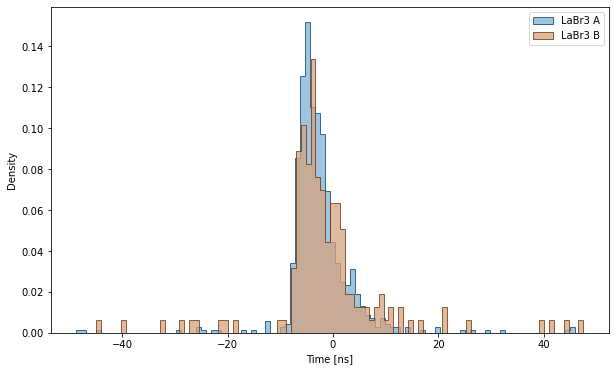

In [189]:
# Plot an histogram of the time distances
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.hist(
    time_distance_a,
    bins      = 100,
    histtype  = "stepfilled", 
    edgecolor = "#06416D", 
    facecolor = "#7eb0d5",
    label     = "LaBr3 A",
    density   = True,
    alpha     = 0.75
)
ax.hist(
    time_distance_b,
    bins      = 100,
    histtype  = "stepfilled", 
    edgecolor = "#6d3206", 
    facecolor = "#d5a37e",
    label     = "LaBr3 B",
    density   = True,
    alpha     = 0.75
)

# display mean and std
# ax.axvline(time_mean_a, color="#06416D", linestyle="--", label=f"Mean: {time_mean_a:.2f}ns")
# ax.axvline(time_mean_a + time_std_a, color="#06416D", linestyle=":", label=f"Std: {time_std_a:.2f}ns")
# ax.axvline(time_mean_a - time_std_a, color="#06416D", linestyle=":")
# ax.axvline(time_mean_b, color="#6d3206", linestyle="--", label=f"Mean: {time_mean_b:.2f}ns")
# ax.axvline(time_mean_b + time_std_b, color="#6d3206", linestyle=":", label=f"Std: {time_std_b:.2f}ns")
# ax.axvline(time_mean_b - time_std_b, color="#6d3206", linestyle=":")

ax.set_xlabel("Time [ns]")
ax.set_ylabel("Density")
ax.legend()
plt.show()

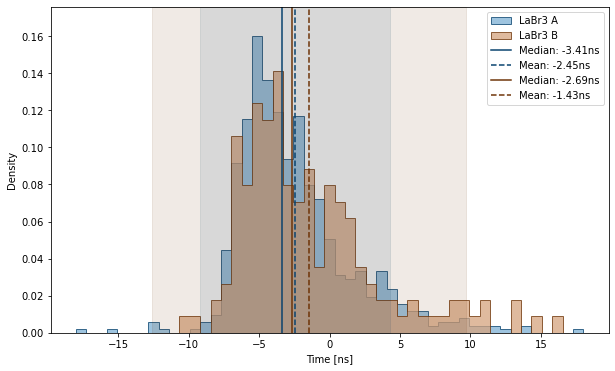

In [190]:
# Plot an histogram of the time distances
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

mask_a = (time_distance_a > -18) & (time_distance_a < 18)
mask_b = (time_distance_b > -18) & (time_distance_b < 18)

bins = np.linspace(-18, 18, 50)

ha, _, _ = ax.hist(
    time_distance_a[mask_a],
    bins      = bins,
    histtype  = "stepfilled", 
    edgecolor = "#06416D", 
    facecolor = "#7eb0d5",
    label     = "LaBr3 A",
    density   = True,
    alpha     = 0.75
)
hb, _, _ = ax.hist(
    time_distance_b[mask_b],
    bins      = bins,
    histtype  = "stepfilled", 
    edgecolor = "#6d3206", 
    facecolor = "#d5a37e",
    label     = "LaBr3 B",
    density   = True,
    alpha     = 0.75
)

# find the maximum of the histogram
h_max = max(ha.max(), hb.max())
h_min = 0

hd = h_max  + (h_max - h_min) * 0.1

# display mean and std
ax.axvline(time_median_a, color="#06416D", linestyle="-", label=f"Median: {time_median_a:.2f}ns")
ax.axvline(time_mean_a, color="#06416D", linestyle="--", label=f"Mean: {time_mean_a:.2f}ns")
ax.fill_betweenx([h_min, hd], time_mean_a - time_std_a, time_mean_a + time_std_a, color="#06416D", alpha=0.1)
ax.axvline(time_median_b, color="#6d3206", linestyle="-", label=f"Median: {time_median_b:.2f}ns")
ax.axvline(time_mean_b, color="#6d3206", linestyle="--", label=f"Mean: {time_mean_b:.2f}ns")
ax.fill_betweenx([h_min, hd], time_mean_b - time_std_b, time_mean_b + time_std_b, color="#6d3206", alpha=0.1)
# ax.set_xlim(-18, 18)

ax.set_ylim(h_min, hd)

ax.set_xlabel("Time [ns]")
ax.set_ylabel("Density")
ax.legend()
plt.show()

In [138]:
time_w = 50

time_distance_a = compute_time_distance(labra_coincidence[labra_coincidence["time_window"] == time_w])
time_distance_b = compute_time_distance(labrb_coincidence[labrb_coincidence["time_window"] == time_w])

In [139]:
# conversion from ps to ns
time_distance_a = np.array(time_distance_a) / 1000
time_distance_b = np.array(time_distance_b) / 1000

In [140]:
# compute mean median and std
time_mean_a = np.mean(time_distance_a)
time_mean_b = np.mean(time_distance_b)
time_median_a = np.median(time_distance_a)
time_median_b = np.median(time_distance_b)
time_std_a = np.std(time_distance_a)
time_std_b = np.std(time_distance_b)

print(f"Mean time difference for {time_w} ns time window: {time_mean_a:.2f}ns (labra), {time_mean_b:.2f}ns (labrb)")
print(f"Median time difference for {time_w} ns time window: {time_median_a:.2f}ns (labra), {time_median_b:.2f}ns (labrb)")
print(f"Std time difference for {time_w} ns time window: {time_std_a:.2f}ns (labra), {time_std_b:.2f}ns (labrb)")

Mean time difference for 50 ns time window: 2.50ns (labra), 1.53ns (labrb)
Median time difference for 50 ns time window: 3.41ns (labra), 2.66ns (labrb)
Std time difference for 50 ns time window: 4.58ns (labra), 6.13ns (labrb)


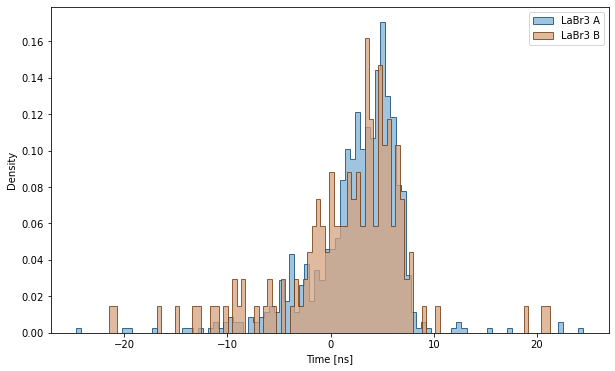

In [141]:
# Plot an histogram of the time distances
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.hist(
    time_distance_a,
    bins      = 100,
    histtype  = "stepfilled", 
    edgecolor = "#06416D", 
    facecolor = "#7eb0d5",
    label     = "LaBr3 A",
    density   = True,
    alpha     = 0.75
)
ax.hist(
    time_distance_b,
    bins      = 100,
    histtype  = "stepfilled", 
    edgecolor = "#6d3206", 
    facecolor = "#d5a37e",
    label     = "LaBr3 B",
    density   = True,
    alpha     = 0.75
)

# display mean and std
# ax.axvline(time_mean_a, color="#06416D", linestyle="--", label=f"Mean: {time_mean_a:.2f}ns")
# ax.axvline(time_mean_a + time_std_a, color="#06416D", linestyle=":", label=f"Std: {time_std_a:.2f}ns")
# ax.axvline(time_mean_a - time_std_a, color="#06416D", linestyle=":")
# ax.axvline(time_mean_b, color="#6d3206", linestyle="--", label=f"Mean: {time_mean_b:.2f}ns")
# ax.axvline(time_mean_b + time_std_b, color="#6d3206", linestyle=":", label=f"Std: {time_std_b:.2f}ns")
# ax.axvline(time_mean_b - time_std_b, color="#6d3206", linestyle=":")

ax.set_xlabel("Time [ns]")
ax.set_ylabel("Density")
ax.legend()
plt.show()

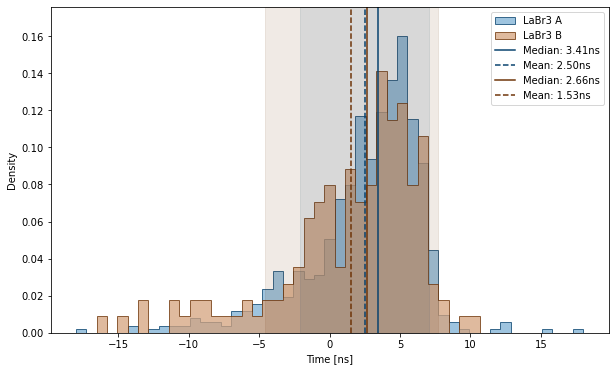

In [142]:
# Plot an histogram of the time distances
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

mask_a = (time_distance_a > -18) & (time_distance_a < 18)
mask_b = (time_distance_b > -18) & (time_distance_b < 18)

bins = np.linspace(-18, 18, 50)

ha, _, _ = ax.hist(
    time_distance_a[mask_a],
    bins      = bins,
    histtype  = "stepfilled", 
    edgecolor = "#06416D", 
    facecolor = "#7eb0d5",
    label     = "LaBr3 A",
    density   = True,
    alpha     = 0.75
)
hb, _, _ = ax.hist(
    time_distance_b[mask_b],
    bins      = bins,
    histtype  = "stepfilled", 
    edgecolor = "#6d3206", 
    facecolor = "#d5a37e",
    label     = "LaBr3 B",
    density   = True,
    alpha     = 0.75
)

# find the maximum of the histogram
h_max = max(ha.max(), hb.max())
h_min = 0

hd = h_max  + (h_max - h_min) * 0.1

# display mean and std
ax.axvline(time_median_a, color="#06416D", linestyle="-", label=f"Median: {time_median_a:.2f}ns")
ax.axvline(time_mean_a, color="#06416D", linestyle="--", label=f"Mean: {time_mean_a:.2f}ns")
ax.fill_betweenx([h_min, hd], time_mean_a - time_std_a, time_mean_a + time_std_a, color="#06416D", alpha=0.1)
ax.axvline(time_median_b, color="#6d3206", linestyle="-", label=f"Median: {time_median_b:.2f}ns")
ax.axvline(time_mean_b, color="#6d3206", linestyle="--", label=f"Mean: {time_mean_b:.2f}ns")
ax.fill_betweenx([h_min, hd], time_mean_b - time_std_b, time_mean_b + time_std_b, color="#6d3206", alpha=0.1)
# ax.set_xlim(-18, 18)

ax.set_ylim(h_min, hd)

ax.set_xlabel("Time [ns]")
ax.set_ylabel("Density")
ax.legend()
plt.show()

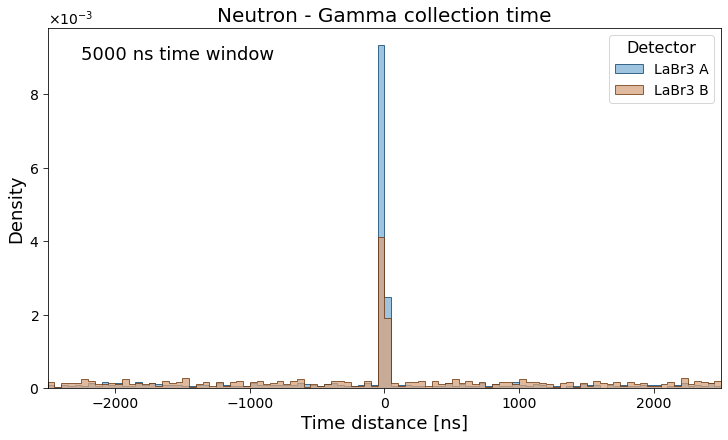

In [24]:
from matplotlib.ticker import ScalarFormatter


time_w = 5000

time_distance_a = compute_time_distance(labra_coincidence[labra_coincidence["time_window"] == time_w])
time_distance_b = compute_time_distance(labrb_coincidence[labrb_coincidence["time_window"] == time_w])

# conversion from ps to ns
time_distance_a = np.array(time_distance_a) / 1000
time_distance_b = np.array(time_distance_b) / 1000

# compute mean median and std
time_mean_a = np.mean(time_distance_a)
time_mean_b = np.mean(time_distance_b)
time_median_a = np.median(time_distance_a)
time_median_b = np.median(time_distance_b)
time_std_a = np.std(time_distance_a)
time_std_b = np.std(time_distance_b)

# print(f"Mean time difference for {time_w} ns time window: {time_mean_a:.2f}ns (labra), {time_mean_b:.2f}ns (labrb)")
# print(f"Median time difference for {time_w} ns time window: {time_median_a:.2f}ns (labra), {time_median_b:.2f}ns (labrb)")
# print(f"Std time difference for {time_w} ns time window: {time_std_a:.2f}ns (labra), {time_std_b:.2f}ns (labrb)")

x_left = -2500
x_right = 2500

bins = np.arange(x_left, x_right, 50)
# add a bin at the end to include the last value
bins  = np.append(bins, x_right)

# Plot an histogram of the time distances
fig, ax = plt.subplots(1, 1, figsize=(10, 6), constrained_layout=True)

ax.hist(
    time_distance_a,
    bins      = bins,
    histtype  = "stepfilled", 
    edgecolor = "#06416D", 
    facecolor = "#7eb0d5",
    label     = "LaBr3 A",
    density   = True,
    alpha     = 0.75,
    stacked=True
)
ax.hist(
    time_distance_b,
    bins      = bins,
    histtype  = "stepfilled", 
    edgecolor = "#6d3206", 
    facecolor = "#d5a37e",
    label     = "LaBr3 B",
    density   = True,
    alpha     = 0.75,
    stacked=True
)

# diplay the time window on the plot 
ax.text(0.05, 0.95, f"{time_w} ns time window", transform=ax.transAxes, fontsize=18, verticalalignment="top")

ax.set_title("Neutron - Gamma collection time", fontsize=20)
ax.set_xlabel("Time distance [ns]", fontsize=18)
ax.set_ylabel("Density", fontsize=18)

ax.tick_params(axis="both", which="major", labelsize=14, length=5)

# display mean and std
# ax.axvline(time_mean_a, color="#06416D", linestyle="--", label=f"Mean: {time_mean_a:.2f}ns")
# ax.axvline(time_mean_a + time_std_a, color="#06416D", linestyle=":", label=f"Std: {time_std_a:.2f}ns")
# ax.axvline(time_mean_a - time_std_a, color="#06416D", linestyle=":")
# ax.axvline(time_mean_b, color="#6d3206", linestyle="--", label=f"Mean: {time_mean_b:.2f}ns")
# ax.axvline(time_mean_b + time_std_b, color="#6d3206", linestyle=":", label=f"Std: {time_std_b:.2f}ns")
# ax.axvline(time_mean_b - time_std_b, color="#6d3206", linestyle=":")

ax.set_xlim(x_left, x_right)

# set y axis in exponential notation
ax.yaxis.get_offset_text().set_fontsize(14)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

ax.legend(fontsize=14, title_fontsize=16, title="Detector", loc="best")

fig.savefig("./plots/t-distance-5000ns.png", dpi=300, facecolor="w")
plt.show()

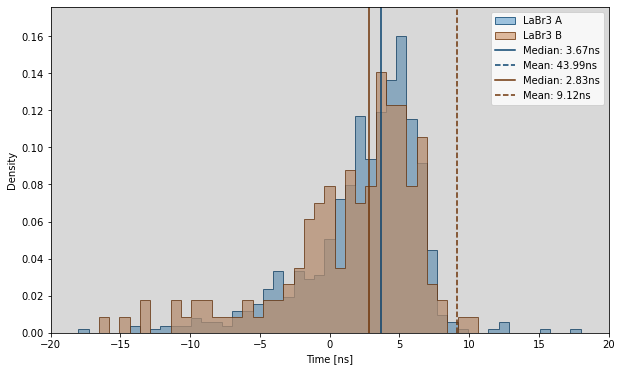

In [148]:
# Plot an histogram of the time distances
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

mask_a = (time_distance_a > -18) & (time_distance_a < 18)
mask_b = (time_distance_b > -18) & (time_distance_b < 18)

bins = np.linspace(-18, 18, 50)

ha, _, _ = ax.hist(
    time_distance_a[mask_a],
    bins      = bins,
    histtype  = "stepfilled", 
    edgecolor = "#06416D", 
    facecolor = "#7eb0d5",
    label     = "LaBr3 A",
    density   = True,
    alpha     = 0.75
)
hb, _, _ = ax.hist(
    time_distance_b[mask_b],
    bins      = bins,
    histtype  = "stepfilled", 
    edgecolor = "#6d3206", 
    facecolor = "#d5a37e",
    label     = "LaBr3 B",
    density   = True,
    alpha     = 0.75
)

# find the maximum of the histogram
h_max = max(ha.max(), hb.max())
h_min = 0

hd = h_max  + (h_max - h_min) * 0.1

# display mean and std
ax.axvline(time_median_a, color="#06416D", linestyle="-", label=f"Median: {time_median_a:.2f}ns")
ax.axvline(time_mean_a, color="#06416D", linestyle="--", label=f"Mean: {time_mean_a:.2f}ns")
ax.fill_betweenx([h_min, hd], time_mean_a - time_std_a, time_mean_a + time_std_a, color="#06416D", alpha=0.1)
ax.axvline(time_median_b, color="#6d3206", linestyle="-", label=f"Median: {time_median_b:.2f}ns")
ax.axvline(time_mean_b, color="#6d3206", linestyle="--", label=f"Mean: {time_mean_b:.2f}ns")
ax.fill_betweenx([h_min, hd], time_mean_b - time_std_b, time_mean_b + time_std_b, color="#6d3206", alpha=0.1)
# ax.set_xlim(-18, 18)

ax.set_ylim(h_min, hd)

ax.set_xlim(-20, 20)

ax.set_xlabel("Time [ns]")
ax.set_ylabel("Density")
ax.legend()
plt.show()

In [149]:
time_w = 500

time_distance_a = compute_time_distance(labra_coincidence[labra_coincidence["time_window"] == time_w])
time_distance_b = compute_time_distance(labrb_coincidence[labrb_coincidence["time_window"] == time_w])

In [150]:
# conversion from ps to ns
time_distance_a = np.array(time_distance_a) / 1000
time_distance_b = np.array(time_distance_b) / 1000

In [151]:
# compute mean median and std
time_mean_a = np.mean(time_distance_a)
time_mean_b = np.mean(time_distance_b)
time_median_a = np.median(time_distance_a)
time_median_b = np.median(time_distance_b)
time_std_a = np.std(time_distance_a)
time_std_b = np.std(time_distance_b)

print(f"Mean time difference for {time_w} ns time window: {time_mean_a:.2f}ns (labra), {time_mean_b:.2f}ns (labrb)")
print(f"Median time difference for {time_w} ns time window: {time_median_a:.2f}ns (labra), {time_median_b:.2f}ns (labrb)")
print(f"Std time difference for {time_w} ns time window: {time_std_a:.2f}ns (labra), {time_std_b:.2f}ns (labrb)")

Mean time difference for 500 ns time window: 3.07ns (labra), -3.26ns (labrb)
Median time difference for 500 ns time window: 3.44ns (labra), 2.62ns (labrb)
Std time difference for 500 ns time window: 35.10ns (labra), 61.74ns (labrb)


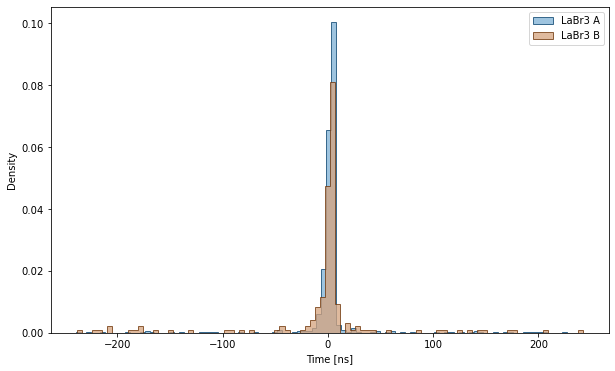

In [152]:
# Plot an histogram of the time distances
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.hist(
    time_distance_a,
    bins      = 100,
    histtype  = "stepfilled", 
    edgecolor = "#06416D", 
    facecolor = "#7eb0d5",
    label     = "LaBr3 A",
    density   = True,
    alpha     = 0.75
)
ax.hist(
    time_distance_b,
    bins      = 100,
    histtype  = "stepfilled", 
    edgecolor = "#6d3206", 
    facecolor = "#d5a37e",
    label     = "LaBr3 B",
    density   = True,
    alpha     = 0.75
)

# display mean and std
# ax.axvline(time_mean_a, color="#06416D", linestyle="--", label=f"Mean: {time_mean_a:.2f}ns")
# ax.axvline(time_mean_a + time_std_a, color="#06416D", linestyle=":", label=f"Std: {time_std_a:.2f}ns")
# ax.axvline(time_mean_a - time_std_a, color="#06416D", linestyle=":")
# ax.axvline(time_mean_b, color="#6d3206", linestyle="--", label=f"Mean: {time_mean_b:.2f}ns")
# ax.axvline(time_mean_b + time_std_b, color="#6d3206", linestyle=":", label=f"Std: {time_std_b:.2f}ns")
# ax.axvline(time_mean_b - time_std_b, color="#6d3206", linestyle=":")

ax.set_xlabel("Time [ns]")
ax.set_ylabel("Density")
ax.legend()
plt.show()

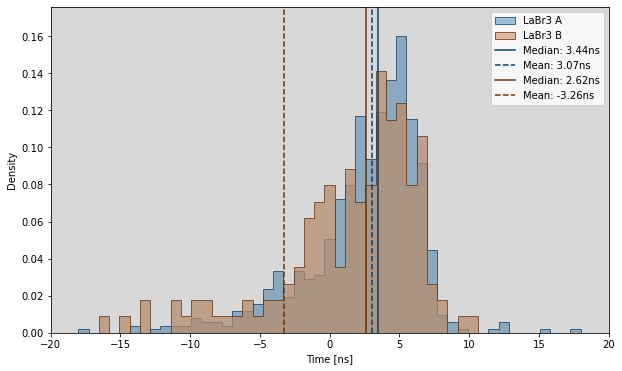

In [154]:
# Plot an histogram of the time distances
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

mask_a = (time_distance_a > -18) & (time_distance_a < 18)
mask_b = (time_distance_b > -18) & (time_distance_b < 18)

bins = np.linspace(-18, 18, 50)

ha, _, _ = ax.hist(
    time_distance_a[mask_a],
    bins      = bins,
    histtype  = "stepfilled", 
    edgecolor = "#06416D", 
    facecolor = "#7eb0d5",
    label     = "LaBr3 A",
    density   = True,
    alpha     = 0.75
)
hb, _, _ = ax.hist(
    time_distance_b[mask_b],
    bins      = bins,
    histtype  = "stepfilled", 
    edgecolor = "#6d3206", 
    facecolor = "#d5a37e",
    label     = "LaBr3 B",
    density   = True,
    alpha     = 0.75
)

# find the maximum of the histogram
h_max = max(ha.max(), hb.max())
h_min = 0

hd = h_max  + (h_max - h_min) * 0.1

# display mean and std
ax.axvline(time_median_a, color="#06416D", linestyle="-", label=f"Median: {time_median_a:.2f}ns")
ax.axvline(time_mean_a, color="#06416D", linestyle="--", label=f"Mean: {time_mean_a:.2f}ns")
ax.fill_betweenx([h_min, hd], time_mean_a - time_std_a, time_mean_a + time_std_a, color="#06416D", alpha=0.1)
ax.axvline(time_median_b, color="#6d3206", linestyle="-", label=f"Median: {time_median_b:.2f}ns")
ax.axvline(time_mean_b, color="#6d3206", linestyle="--", label=f"Mean: {time_mean_b:.2f}ns")
ax.fill_betweenx([h_min, hd], time_mean_b - time_std_b, time_mean_b + time_std_b, color="#6d3206", alpha=0.1)
# ax.set_xlim(-18, 18)

ax.set_ylim(h_min, hd)
ax.set_xlim(-20, 20)

ax.set_xlabel("Time [ns]")
ax.set_ylabel("Density")
ax.legend()
plt.show()

In [173]:
time_w = 50

time_distance_a = compute_time_distance(labra_coincidence[labra_coincidence["time_window"] == time_w])
time_distance_b = compute_time_distance(labrb_coincidence[labrb_coincidence["time_window"] == time_w])

In [174]:
# conversion from ps to ns
time_distance_a = np.array(time_distance_a) / 1000
time_distance_b = np.array(time_distance_b) / 1000

In [175]:
# compute mean median and std
time_mean_a = np.mean(time_distance_a)
time_mean_b = np.mean(time_distance_b)
time_median_a = np.median(time_distance_a)
time_median_b = np.median(time_distance_b)
time_std_a = np.std(time_distance_a)
time_std_b = np.std(time_distance_b)

print(f"Mean time difference for {time_w} ns time window: {time_mean_a:.2f}ns (labra), {time_mean_b:.2f}ns (labrb)")
print(f"Median time difference for {time_w} ns time window: {time_median_a:.2f}ns (labra), {time_median_b:.2f}ns (labrb)")
print(f"Std time difference for {time_w} ns time window: {time_std_a:.2f}ns (labra), {time_std_b:.2f}ns (labrb)")

Mean time difference for 50 ns time window: 2.50ns (labra), 1.53ns (labrb)
Median time difference for 50 ns time window: 3.41ns (labra), 2.66ns (labrb)
Std time difference for 50 ns time window: 4.58ns (labra), 6.13ns (labrb)


In [181]:
# select only times between -20 and +20 ns
mask_a = (time_distance_a > -20) & (time_distance_a < 20)
mask_b = (time_distance_b > -20) & (time_distance_b < 20)

time_distance_a_sel = time_distance_a[mask_a]
time_distance_b_sel = time_distance_b[mask_b]

var_a = np.var(time_distance_a_sel)
var_b = np.var(time_distance_b_sel)

print(f"Variance time difference for {time_w} ns time window: {var_a:.2f}ns (labra), {var_b:.2f}ns (labrb)")

Variance time difference for 50 ns time window: 17.52ns (labra), 27.01ns (labrb)


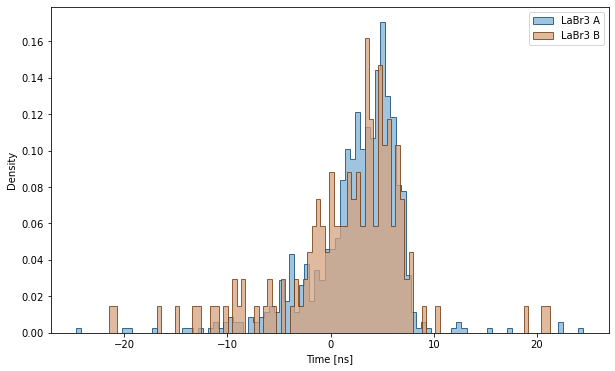

In [176]:
# Plot an histogram of the time distances
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.hist(
    time_distance_a,
    bins      = 100,
    histtype  = "stepfilled", 
    edgecolor = "#06416D", 
    facecolor = "#7eb0d5",
    label     = "LaBr3 A",
    density   = True,
    alpha     = 0.75
)
ax.hist(
    time_distance_b,
    bins      = 100,
    histtype  = "stepfilled", 
    edgecolor = "#6d3206", 
    facecolor = "#d5a37e",
    label     = "LaBr3 B",
    density   = True,
    alpha     = 0.75
)

# display mean and std
# ax.axvline(time_mean_a, color="#06416D", linestyle="--", label=f"Mean: {time_mean_a:.2f}ns")
# ax.axvline(time_mean_a + time_std_a, color="#06416D", linestyle=":", label=f"Std: {time_std_a:.2f}ns")
# ax.axvline(time_mean_a - time_std_a, color="#06416D", linestyle=":")
# ax.axvline(time_mean_b, color="#6d3206", linestyle="--", label=f"Mean: {time_mean_b:.2f}ns")
# ax.axvline(time_mean_b + time_std_b, color="#6d3206", linestyle=":", label=f"Std: {time_std_b:.2f}ns")
# ax.axvline(time_mean_b - time_std_b, color="#6d3206", linestyle=":")

ax.set_xlabel("Time [ns]")
ax.set_ylabel("Density")
ax.legend()
plt.show()

Variance time difference for 50 ns time window: 17.52ns (labra), 27.01ns (labrb)
Mean time difference for 50 ns time window: 2.48ns (labra), 1.57ns (labrb)
Median time difference for 50 ns time window: 3.40ns (labra), 2.66ns (labrb)
Std time difference for 50 ns time window: 4.19ns (labra), 5.20ns (labrb)


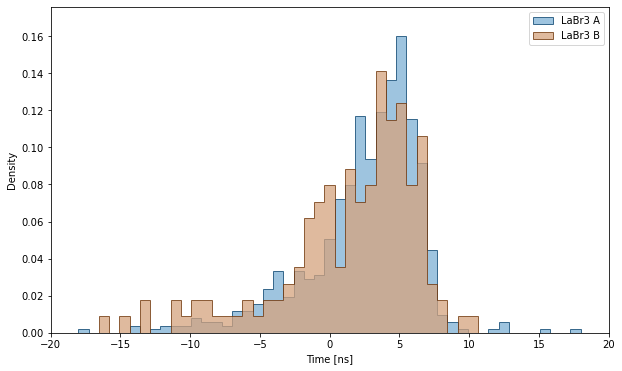

In [184]:
# Plot an histogram of the time distances
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# select only times between -20 and +20 ns
mask_a = (time_distance_a > -20) & (time_distance_a < 20)
mask_b = (time_distance_b > -20) & (time_distance_b < 20)

time_distance_a = time_distance_a[mask_a]
time_distance_b = time_distance_b[mask_b]

var_a = np.var(time_distance_a)
var_b = np.var(time_distance_b)

print(f"Variance time difference for {time_w} ns time window: {var_a:.2f}ns (labra), {var_b:.2f}ns (labrb)")

# compute mean median and std
time_mean_a = np.mean(time_distance_a)
time_mean_b = np.mean(time_distance_b)
time_median_a = np.median(time_distance_a)
time_median_b = np.median(time_distance_b)
time_std_a = np.std(time_distance_a)
time_std_b = np.std(time_distance_b)

print(f"Mean time difference for {time_w} ns time window: {time_mean_a:.2f}ns (labra), {time_mean_b:.2f}ns (labrb)")
print(f"Median time difference for {time_w} ns time window: {time_median_a:.2f}ns (labra), {time_median_b:.2f}ns (labrb)")
print(f"Std time difference for {time_w} ns time window: {time_std_a:.2f}ns (labra), {time_std_b:.2f}ns (labrb)")

bins = np.linspace(-18, 18, 50)

ha, _, _ = ax.hist(
    time_distance_a,
    bins      = bins,
    histtype  = "stepfilled", 
    edgecolor = "#06416D", 
    facecolor = "#7eb0d5",
    label     = "LaBr3 A",
    density   = True,
    alpha     = 0.75
)
hb, _, _ = ax.hist(
    time_distance_b,
    bins      = bins,
    histtype  = "stepfilled", 
    edgecolor = "#6d3206", 
    facecolor = "#d5a37e",
    label     = "LaBr3 B",
    density   = True,
    alpha     = 0.75
)

# find the maximum of the histogram
h_max = max(ha.max(), hb.max())
h_min = 0

hd = h_max  + (h_max - h_min) * 0.1

# display mean and std
# ax.axvline(time_median_a, color="#06416D", linestyle="-", label=f"Median: {time_median_a:.2f}ns")
# ax.axvline(time_mean_a, color="#06416D", linestyle="--", label=f"Mean: {time_mean_a:.2f}ns")
# ax.fill_betweenx([h_min, hd], time_mean_a - time_std_a, time_mean_a + time_std_a, color="#06416D", alpha=0.1)
# ax.axvline(time_median_b, color="#6d3206", linestyle="-", label=f"Median: {time_median_b:.2f}ns")
# ax.axvline(time_mean_b, color="#6d3206", linestyle="--", label=f"Mean: {time_mean_b:.2f}ns")
# ax.fill_betweenx([h_min, hd], time_mean_b - time_std_b, time_mean_b + time_std_b, color="#6d3206", alpha=0.1)
# ax.set_xlim(-18, 18)

ax.set_ylim(h_min, hd)
ax.set_xlim(-20, 20)

ax.set_xlabel("Time [ns]")
ax.set_ylabel("Density")
ax.legend()
plt.show()

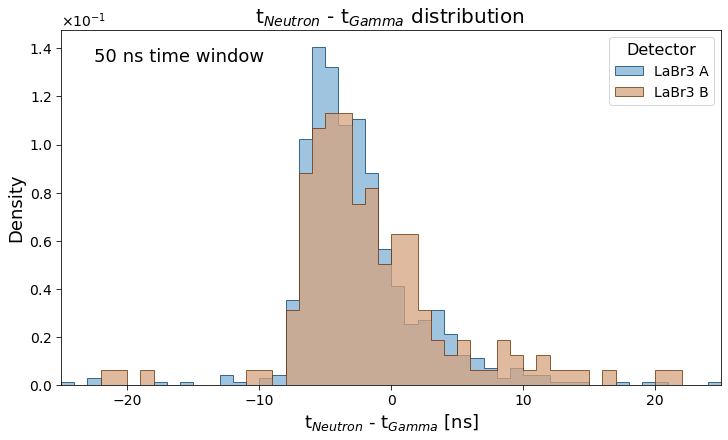

In [35]:
from matplotlib.ticker import ScalarFormatter


time_w = 50

time_distance_a = compute_time_distance(labra_coincidence[labra_coincidence["time_window"] == time_w])
time_distance_b = compute_time_distance(labrb_coincidence[labrb_coincidence["time_window"] == time_w])

# conversion from ps to ns
time_distance_a = np.array(time_distance_a) / 1000
time_distance_b = np.array(time_distance_b) / 1000

# compute mean median and std
time_mean_a = np.mean(time_distance_a)
time_mean_b = np.mean(time_distance_b)
time_median_a = np.median(time_distance_a)
time_median_b = np.median(time_distance_b)
time_std_a = np.std(time_distance_a)
time_std_b = np.std(time_distance_b)

# print(f"Mean time difference for {time_w} ns time window: {time_mean_a:.2f}ns (labra), {time_mean_b:.2f}ns (labrb)")
# print(f"Median time difference for {time_w} ns time window: {time_median_a:.2f}ns (labra), {time_median_b:.2f}ns (labrb)")
# print(f"Std time difference for {time_w} ns time window: {time_std_a:.2f}ns (labra), {time_std_b:.2f}ns (labrb)")

x_left = -time_w // 2
x_right = time_w // 2

bins = np.arange(x_left, x_right, 1)
# add a bin at the end to include the last value
bins  = np.append(bins, x_right)

# Plot an histogram of the time distances
fig, ax = plt.subplots(1, 1, figsize=(10, 6), constrained_layout=True)

ax.hist(
    time_distance_a,
    bins      = bins,
    histtype  = "stepfilled", 
    edgecolor = "#06416D", 
    facecolor = "#7eb0d5",
    label     = "LaBr3 A",
    density   = True,
    alpha     = 0.75,
    stacked=True
)
ax.hist(
    time_distance_b,
    bins      = bins,
    histtype  = "stepfilled", 
    edgecolor = "#6d3206", 
    facecolor = "#d5a37e",
    label     = "LaBr3 B",
    density   = True,
    alpha     = 0.75,
    stacked=True
)

# diplay the time window on the plot 
ax.text(0.05, 0.95, f"{time_w} ns time window", transform=ax.transAxes, fontsize=18, verticalalignment="top")

ax.set_title("t$_{Neutron}$ - t$_{Gamma}$ distribution ", fontsize=20)
ax.set_xlabel("t$_{Neutron}$ - t$_{Gamma}$ [ns]", fontsize=18)
ax.set_ylabel("Density", fontsize=18)

ax.tick_params(axis="both", which="major", labelsize=14, length=5)

# display mean and std
# ax.axvline(time_mean_a, color="#06416D", linestyle="--", label=f"Mean: {time_mean_a:.2f}ns")
# ax.axvline(time_mean_a + time_std_a, color="#06416D", linestyle=":", label=f"Std: {time_std_a:.2f}ns")
# ax.axvline(time_mean_a - time_std_a, color="#06416D", linestyle=":")
# ax.axvline(time_mean_b, color="#6d3206", linestyle="--", label=f"Mean: {time_mean_b:.2f}ns")
# ax.axvline(time_mean_b + time_std_b, color="#6d3206", linestyle=":", label=f"Std: {time_std_b:.2f}ns")
# ax.axvline(time_mean_b - time_std_b, color="#6d3206", linestyle=":")

ax.set_xlim(x_left, x_right)

# set y axis in exponential notation
ax.yaxis.get_offset_text().set_fontsize(14)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

ax.legend(fontsize=14, title_fontsize=16, title="Detector", loc="best")

# fig.savefig(f"./plots/t-distance-{time_w}ns.png", dpi=300, facecolor="w")
plt.show()